In [1335]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from abc import ABC, abstractmethod
from subprocess import call
from scipy import stats
from IPython.display import Image
from uncertainties import unumpy, ufloat
from sklearn.model_selection import train_test_split as dataSplitter
from sklearn.model_selection import GridSearchCV
from sklearn.base import ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.svm import SVC as skSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.utils.class_weight import compute_sample_weight
import sklearn.metrics as metric

In [1336]:
promptRate=.092
pizRate  = 1-promptRate
pizRate

0.908

# Make an abstract algorithm and instances for each machine I want to test##

In [1337]:
#in future version add roc inside here 
class Algo:
	def __init__(self,trainData,testData):
		self.classifier  = ClassifierMixin()
		self.train(trainData)
		self.test = testData
	@abstractmethod
	def train(self,data):
		pass
	@abstractmethod
	def getName(self,data):
		pass
	def score(self):
		print(self.getName()+"\n\t F1: "+str(metric.f1_score(self.test['isPhoton'],self.predict(self.test.drop(['isPhoton'],axis=1)),average='binary',sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))))
		print("\t Precision: "+str(metric.precision_score(self.test['isPhoton'],self.predict(self.test.drop(['isPhoton'],axis=1)),average='binary',sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))))
		print("\t Recall: "+str(metric.recall_score(self.test['isPhoton'],self.predict(self.test.drop(['isPhoton'],axis=1)),average='binary',sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))))
		chanceLabels = [0 for i in range(len(self.test['isPhoton']))]
		chanceLabels[0::10] = [1 for i in range(len(chanceLabels[0::10]))]
		print("\t Kappa: "+str(metric.cohen_kappa_score(chanceLabels,self.predict(self.test.drop(['isPhoton'],axis=1)),sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))))
		print("\t Matrix: "+str(metric.confusion_matrix(self.test['isPhoton'],self.predict(self.test.drop(['isPhoton'],axis=1)),sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))))
	def best_param(self):
		print(self.classifier.best_params_)
	def estimate(self,cluster):
		return self.classifier.predict_proba(cluster)
	def predict(self,cluster):
		return self.classifier.predict(cluster)
	def make_roc(self):
		#print(self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])
		return roc_curve(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1],sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))
	def make_prc(self):
		#print(self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1])
		return metric.precision_recall_curve(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1],sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton'])), metric.average_precision_score(self.test['isPhoton'],self.estimate(self.test.drop(['isPhoton'],axis=1))[:,1],sample_weight=compute_sample_weight({0:pizRate,1:promptRate},self.test['isPhoton']))

In [1338]:
class Sasha(Algo):
    def __intit__(self,trainData,testData):
        Algo.__init__(trainData,testData)
    def train(self,data):
        #does nothing algo comes pretrained
        return
    def getName(self):
        return "Sasha"
    def estimate(self,cluster):
        estimates = cluster['sProb'].values
        return estimates
    def make_roc(self):
        return roc_curve(self.test['isPhoton'],self.estimate(self.test))

In [1339]:
class kNN(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skKNN(),{'n_neighbors':[24,32,38]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "kNN"

In [1340]:
class LDA(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skLDA(solver='lsqr'),{'tol':[1e-4,1e-5,1e-3]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "LDA"

In [1341]:
class Logistic(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000,class_weight={1: promptRate, 0:pizRate}),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "Logistic"

In [1342]:
class SVC(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)

	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(skSVC(kernel='linear',gamma='scale',probability=True,class_weight={1: promptRate, 0:pizRate}),{'tol':[1e-4,1e-5,1e-4],'C':[.1,1,10]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "SVC"

In [1343]:
class BDT(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(AdaBoostClassifier(),{'n_estimators':[10000,1000],'learning_rate':[.1,1,.01]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "BDT"

In [1344]:
class RandomForest(Algo):
	def __intit__(self,trainData,testData):
		Algo.__init__(trainData,testData)
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(RandomForestClassifier(class_weight={1:promptRate,0:pizRate}),{'n_estimators':[100,250,400]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "RandomForest"

In [1345]:
class MLP(Algo):
	def __intit__(self,trainData,testData):
		trainData, testData = scaler(trainData,testData)
		Algo.__init__(trainData,testData)
		self.name="MLP"
	def scaler(self,train,test):
		_scaler = StandardScaler()
		_scaler.fit_transform(train)
		_scaler.transform(test)
		return train, test
	def train(self,data):
        #split data and score
		self.classifier = GridSearchCV(MLPClassifier(early_stopping=True,warm_start=True),{'alpha':[1e-4,1e-3,1e-5],'learning_rate_init':[1e-2,1e-3,1e-1],'epsilon':[1e-9,1e-8,1e-10],'hidden_layer_sizes':[[17,17],[10],[10,10]]},cv=5).fit(data.drop(['isPhoton'],axis=1),data['isPhoton'])
	def getName(self):
		return "MLP"

# Model Evaluation Functions

In [1346]:
def plotRoc(algos):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y','c','k'])))
    lw = len(algos) + 1
    for algo in algos:
        print(algo.getName())
        fpr[algo], tpr[algo],_ = algo.make_roc()
        roc_auc[algo] = auc(fpr[algo],tpr[algo])
        plt.plot(fpr[algo], tpr[algo],
         lw=lw, label=algo.getName()+' (area = %0.2f)' % roc_auc[algo])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [1347]:
def plotPRC(algos):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    average = dict()
    plt.figure()
    plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y','c','k'])))
    lw = len(algos) + 1
    for algo in algos:
        print(algo.getName())
        plot, average[algo] = algo.make_prc()
        fpr[algo]= plot[0]
        tpr[algo]= plot[1]
        plt.plot(fpr[algo], tpr[algo],
         lw=lw, label=algo.getName()+' (average score = %0.2f)' % average[algo])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right")
    plt.show()

In [1348]:
def diagnoseForest(model,names):
    index = 0
    #for estimator in model.estimators_:
    estimator = model.estimators_[5]
    title = 'tree'+str(index)+'.dot'
    export_graphviz(estimator, out_file=title, 
                feature_names = names,
                class_names = ['Jet','Photon'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    newTitle = 'tree'+str(index)+'.png'
    call(['dot','-Tpng', title, '-o', newTitle, '-Gdpi=600'])
    Image(filename = newTitle)
    index = index+1

In [1349]:
def forestImportance(forest,featureNames):
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(len(featureNames)):
        print("%d. %s (%f)" % (f + 1, featureNames[indices[f]], importances[indices[f]]))
    
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(len(featureNames)), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(len(featureNames)), [x for _,x in sorted(zip(indices,featureNames))],rotation=45)
    plt.xlim([-1, len(featureNames)])
    plt.show()

# Data Transformations

In [1350]:
def removeCombined(val):
    if val == -998:
        return np.nan
    else:
        return val

In [1351]:
def pid2Type(val):
    if abs(val) in [311,313,421,423,511,513,111,113,130,221,331]:
        return 0
    else:
        return 1

In [1352]:
def toNA(val):
    if val==-999:
        return np.nan
    else:
        return val

In [1353]:
def to0(val):
    if val==-999:
        return 0
    else:
        return val

# Data Input

In [1354]:
def csvToInput(signal,back):
    dfs = pd.read_csv(signal)
    dfb = pd.read_csv(back)
    df = dfs.append(dfb)
    df = df.groupby(['isPhoton']).get_group(1)
    df= df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    df = df[df['total_energy']>13]
    df = df[df['total_energy']<22]
    #groups = df.groupby(['pid'])
    #photons = groups.get_group(22)
    #photons['total_energy'].hist()
    #return photons
    train, test = dataSplitter(df.values,test_size=.2,shuffle=True)
    train = pd.DataFrame(columns=df.columns,data=train)
    test = pd.DataFrame(columns=df.columns,data=test)
    return train,test

In [1355]:
train, test = csvToInput("singleClusters.csv","sback.csv")
trainS = train
testS = test
train = train.drop(['sProb','cal_energy'],axis=1)
test = test.drop(['sProb','cal_energy'],axis=1)
train.head()

,Unnamed: 0,total_energy,core_energy,isPhoton,tower0,tower1,tower2,tower3,tower4,tower5,...,tower39,tower40,tower41,tower42,tower43,tower44,tower45,tower46,tower47,tower48
0,7635.0,13.729648,14.212836,1.0,-999.00000,-999.00000,-999.0,-999.0,-999.0,-999.0,...,-999.000000,-999.000000,-999.0,-999.0,-999.0,0.048641,-999.0,-999.0,-999.0,-999.0
1,11685.0,15.343515,15.647348,1.0,-999.00000,-999.00000,-999.0,-999.0,-999.0,-999.0,...,-999.000000,0.050257,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0
2,16606.0,19.299986,18.359312,0.0,0.03797,0.04008,-999.0,-999.0,-999.0,-999.0,...,0.081895,0.048297,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0
3,2696.0,17.649096,17.398968,0.0,-999.00000,-999.00000,-999.0,-999.0,-999.0,-999.0,...,0.087669,-999.000000,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0
4,3575.0,14.842518,14.432292,0.0,-999.00000,-999.00000,-999.0,-999.0,-999.0,-999.0,...,-999.000000,0.048718,-999.0,-999.0,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0


# Initial Distribution Analysis

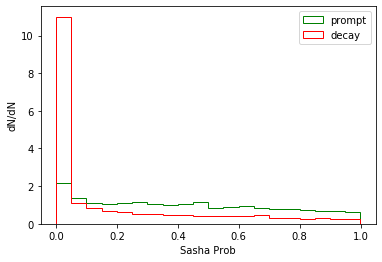

In [1356]:
groups = trainS.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['sProb'].values,groups.get_group(1)['sProb'].values], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Sasha Prob")
plt.ylabel("dN/dN")
plt.title("")
plt.legend()
plt.show()

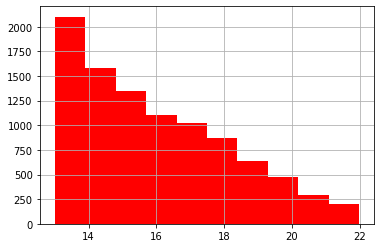

In [1357]:
train['total_energy'].hist()

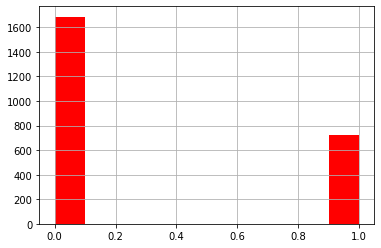

In [1358]:
test['isPhoton'].hist()

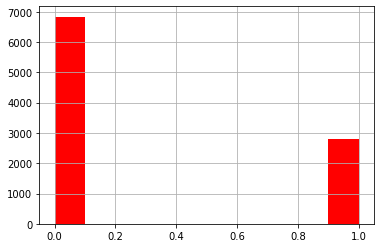

In [1359]:
train['isPhoton'].hist()

Try to make some engineered features based off the symmetry of a photon.

# Feature Engineering

In [1360]:
def integrated_perimeter(df):
    perimeter_values = [1,2,3,4,5,6,7,13,14,20,21,27,28,34,35,41,42,43,44,45,46,47,48]
    name = 'tower'
    df['integrated_perimeter'] = df['tower0']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['integrated_perimeter'] = df['integrated_perimeter']+df[title]
        #df.drop([title])
    return df
        

In [1361]:
def max_finder(df):
    perimeter_values = [9,10,11,12,15,19,22,26,29,33,36,37,38,39,40]
    name = 'tower'
    df['max_perimeter'] = df['tower8']
    #df.drop(['tower0'])
    for i in perimeter_values:
        title = name+str(i)
        df['max_perimeter'] = df['max_perimeter']+df[title]
        #df.drop([title])
    return df

In [1362]:
def asymmetry(df):
    top = [8,9,10,11,12,15,16,17,18,19]    
    bottom = [29,30,31,32,33,36,37,38,39,40]
    left = [8,9,15,16,22,23,29,30,36,37,43,44]
    right= [11,12,18,19,25,26,32,33,39,40]
    series1 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series2 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series3 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    series4 = pd.Series(0 for i in range(0,len(df['isPhoton'])))
    name = 'tower'
    for i,j,k,c in zip(top,bottom,left,right):
        title = name+str(i)
        series1 = series1 + df[title]
        title = name+str(j)
        series2 = series2 + df[title]
        title = name+str(k)
        series3 = series3 + df[title]
        title = name+str(c)
        series4 = series4 + df[title]
    df['top_asymmetry'] = abs(series1-series2)
    df['left_asymmetry']= abs(series3-series4)
    return df

In [1363]:
def preprocess(train):
    trainTransformed = pd.DataFrame()
    for column in train:
        trainTransformed[column]  = train[column].apply(to0)
    #print(trainTransformed.head())
    trainTransformed = integrated_perimeter(trainTransformed)
    trainTransformed = asymmetry(trainTransformed)
    trainTransformed = max_finder(trainTransformed)
    trainTransformed = trainTransformed.drop(['tower0','tower1','tower2','tower3','tower4','tower5','tower6','tower7','tower8','tower9','tower10','tower11','tower12','tower13','tower14','tower15','tower19','tower20','tower21','tower22','tower26','tower27','tower28','tower29','tower33','tower34','tower35','tower36','tower40','tower41','tower42','tower43','tower44','tower45','tower46','tower47','tower48'],axis=1)    
    df_temp = trainTransformed.drop(['isPhoton','total_energy'],axis=1)
    for column in df_temp:
        df_temp[column] = df_temp[column] / trainTransformed['total_energy']
    trainTransformed = trainTransformed[['isPhoton','total_energy']]
    trainTransformed = pd.concat([trainTransformed,df_temp.drop('Unnamed: 0',axis=1)],axis=1)
    return trainTransformed

In [1364]:
train = preprocess(train)
test = preprocess(test)
#train = train.drop('total_energy',axis=1)
#test = test.drop('total_energy',axis=1)
train.head()

,isPhoton,total_energy,core_energy,tower16,tower17,tower18,tower23,tower24,tower25,tower30,tower31,tower32,tower37,tower38,tower39,integrated_perimeter,top_asymmetry,left_asymmetry,max_perimeter
0,1.0,13.729648,1.035193,0.041338,0.209939,0.004645,0.135005,0.587707,0.009444,0.007107,0.002781,0.002781,0.000000,0.000000,0.000000,0.003543,0.246838,0.171679,0.017964
1,1.0,15.343515,1.019802,0.003150,0.005204,0.000000,0.032572,0.785694,0.014917,0.011359,0.130424,0.014370,0.000000,0.005459,0.000000,0.000000,0.158579,0.017387,0.016804
2,0.0,19.299986,0.951260,0.006859,0.020685,0.007403,0.012194,0.780168,0.030157,0.009357,0.060494,0.052769,0.000000,0.004787,0.004243,0.006657,0.103882,0.071604,0.027533
3,0.0,17.649096,0.985828,0.006563,0.008265,0.000000,0.019081,0.446771,0.008508,0.129877,0.340806,0.005573,0.011025,0.010177,0.004967,0.000000,0.492808,0.153073,0.039765
4,0.0,14.842518,0.972361,0.055573,0.134004,0.194149,0.041144,0.547160,0.007286,0.003140,0.006279,0.003425,0.003140,0.003568,0.000000,0.000000,0.375281,0.106980,0.035514


# Feature Analysis

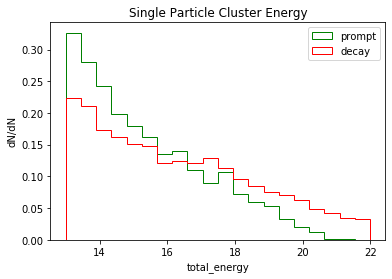

In [1365]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['total_energy'].values,groups.get_group(1)['total_energy'].values], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("total_energy")
plt.ylabel("dN/dN")
plt.title("Single Particle Cluster Energy")
plt.legend()
plt.show()

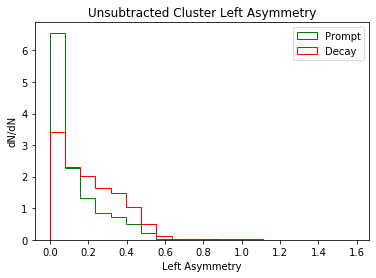

In [1366]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['left_asymmetry'].values,groups.get_group(1)['left_asymmetry'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Left Asymmetry")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Left Asymmetry")
plt.legend()
plt.show()

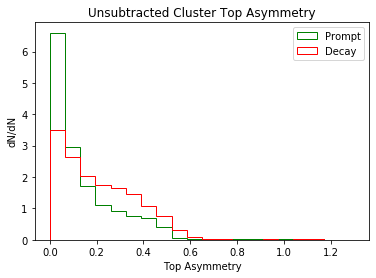

In [1367]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['top_asymmetry'].values,groups.get_group(1)['top_asymmetry'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Top Asymmetry")
plt.ylabel("dN/dN")
plt.title("Unsubtracted Cluster Top Asymmetry")
plt.legend()
plt.show()

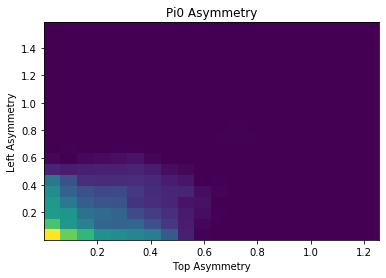

In [1368]:
groups = train.groupby(['isPhoton'])
plt.hist2d(groups.get_group(0)['top_asymmetry'].values,
           groups.get_group(0)['left_asymmetry'].values,
           bins=20,density=True)
plt.xlabel("Top Asymmetry")
plt.ylabel("Left Asymmetry")
plt.title("Pi0 Asymmetry")
plt.show()

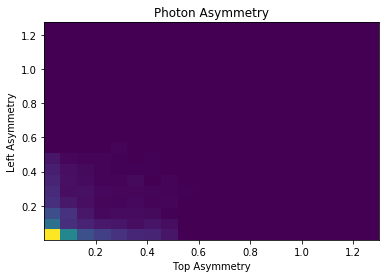

In [1369]:
groups = train.groupby(['isPhoton'])
plt.hist2d(groups.get_group(1)['top_asymmetry'].values,
           groups.get_group(1)['left_asymmetry'].values,
           bins=20,density=True)
plt.xlabel("Top Asymmetry")
plt.ylabel("Left Asymmetry")
plt.title("Photon Asymmetry")
plt.show()

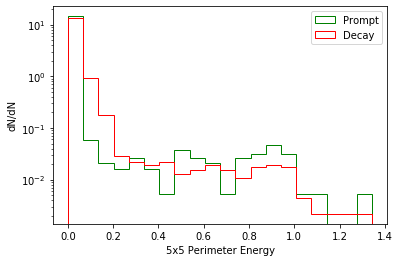

In [1387]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['max_perimeter'].values,groups.get_group(1)['max_perimeter'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("5x5 Perimeter Energy")
plt.ylabel("dN/dN")
plt.yscale('log')
plt.legend()
plt.show()

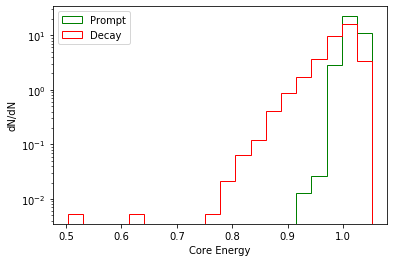

In [1389]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['core_energy'].values,groups.get_group(1)['core_energy'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Core Energy")
plt.ylabel("dN/dN")
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()

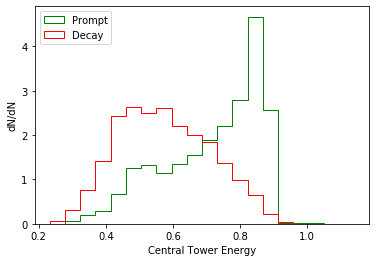

In [1396]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['tower24'].values,groups.get_group(1)['tower24'].values], bins=20,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Central Tower Energy")
plt.ylabel("dN/dN")
plt.legend(loc="upper left")
plt.show()

[11 12 13 14 15 16 17 18 19 20 21 22]
[0.    0.125 0.25  0.5   0.625 0.75  1.    1.5   2.5  ]


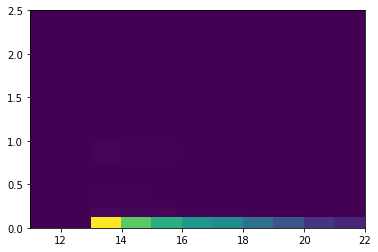

In [1371]:
energybins=[11,12,13,14,15,16,17,18,19,20,21,22]
ybins = [0,.125,.25,.5,.625,.75,1.,1.5,2.5]
total_hist,x,y,i = plt.hist2d(train['total_energy'].values,train['max_perimeter'].values,[energybins,ybins])
total_hist = np.array(total_hist)
print(x)
print(y)

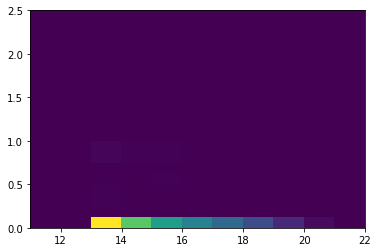

In [1372]:
groups = train.groupby(['isPhoton'])
prompt_hist,x,y,i = plt.hist2d(groups.get_group(1)['total_energy'].values,groups.get_group(1)['max_perimeter'].values,bins=[energybins,ybins])
prompt_hist = np.array(prompt_hist)
ratio = np.divide(prompt_hist,total_hist,out=np.zeros_like(prompt_hist),where = total_hist!=0)
i

In [1373]:
make2dHistTrend(prompt_hist,energybins,ybins)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
 [nan,
  nan,
  0.01558679706601467,
  0.012708333333333334,
  0.013215859030837005,
  0.00847457627118644,
  0.006386861313868613,
  0.004704301075268817,
  0.017105263157894738,
  0.028846153846153848,
  0.0],
 [nan,
  nan,
  0.0003650743136316538,
  0.00038876505169326524,
  0.0003829777562135456,
  0.00030331660332244293,
  0.0002103805208459546,
  0.00023645147531867937,
  0.0008701109511974445,
  0.004190515708080856,
  -0.0])

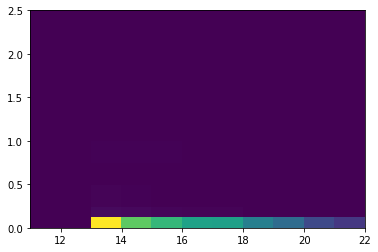

In [1374]:
decay_hist,x,y,i = plt.hist2d(groups.get_group(0)['total_energy'].values,groups.get_group(0)['max_perimeter'].values,bins=[energybins,ybins])


In [1375]:
def make2dHistTrend(data,xbins,ybins):
    #find the mean 5x5 value for each clusterE
    means = []
    #loop over each column
    for row in data:
        #calculate column mean with uncertainty
        rval=0
        #weight the y value of each bin by the count
        for total,yval in zip(row,ybins[0:len(ybins)-1]):
            rval+=total*yval
        #divide by the total weight to get the mean
        rval/=sum(row)
        means.append(rval)
    #calculate s
    stwos = []
    for row,mean in zip(data,means):
        #calculate column mean with uncertainty
        rval=0
        #weight the y value of each bin by the count
        for total,yval in zip(row,ybins[0:len(ybins)-1]):
            rval+=total*(yval-mean)**2
        #divide by the total weight to get the mean
        rval/=sum(row-1)
        stwos.append(rval)
    
    #print means
    uncertainties=[]
    for st,row in zip(stwos,data):
        uncertainties.append(st/(sum(row)**(1./2)))
    return xbins[0:len(xbins)-1],means,uncertainties

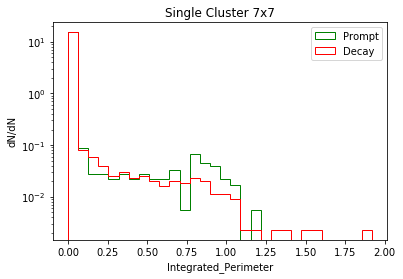

In [1376]:
groups = train.groupby(['isPhoton'])
plt.hist([groups.get_group(0)['integrated_perimeter'].values,groups.get_group(1)['integrated_perimeter'].values], bins=30,density=True,histtype='step',label=["Decay","Prompt"])
plt.xlabel("Integrated_Perimeter")
plt.ylabel("dN/dN")
plt.yscale('log')
plt.title("Single Cluster 7x7")
plt.legend()
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


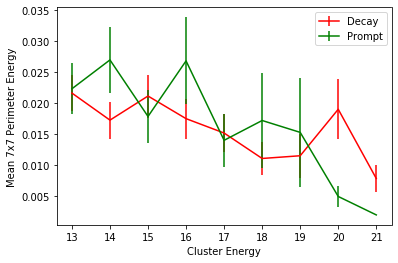

In [1377]:
#prompt = make2dHistTrend(pdata,x,y)
dmeans = myBinnedStat(groups.get_group(0)['total_energy'],groups.get_group(0)['integrated_perimeter'],energybins)
pmeans = myBinnedStat(groups.get_group(1)['total_energy'],groups.get_group(1)['integrated_perimeter'],energybins)
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in dmeans],yerr=[m.s for m in dmeans])
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in pmeans],yerr=[m.s for m in pmeans])
plt.xlabel("Cluster Energy")
plt.ylabel("Mean 7x7 Perimeter Energy")
plt.legend(["Decay","Prompt"])

# Training

knn = kNN(train,test)

knn.score()

knn.best_param()

lda  = LDA(train,test)

In [1378]:
logistic  = Logistic(train,test)

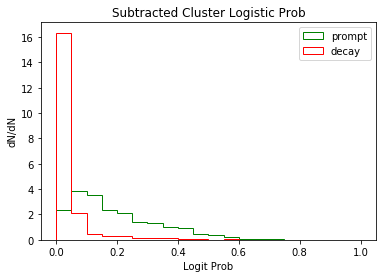

In [1379]:
groups = test.groupby(['isPhoton'])
plt.hist([logistic.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , logistic.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Logit Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster Logistic Prob")
plt.legend()
plt.show()

In [1380]:
logistic.score()

Logistic
	 F1: 0.06418030587604029
	 Precision: 0.30510204081632664
	 Recall: 0.0358620689655176
	 Kappa: 0.0066768849131622066
	 Matrix: [[1526.348    5.448]
 [  64.308    2.392]]


In [1381]:
randomForest = RandomForest(train,test)

In [1382]:
randomForest.score()

RandomForest
	 F1: 0.3874398105306043
	 Precision: 0.2623295526952937
	 Recall: 0.7406896551724147
	 Kappa: -0.0013973691306474745
	 Matrix: [[1392.872  138.924]
 [  17.296   49.404]]


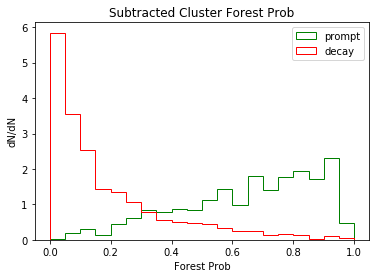

In [1383]:
groups = test.groupby(['isPhoton'])
plt.hist([randomForest.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , randomForest.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("Forest Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster Forest Prob")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prompt Photons')

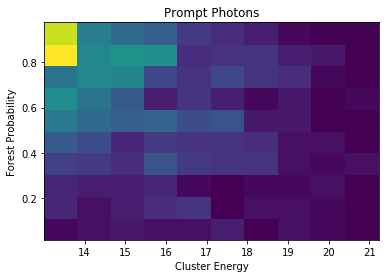

In [1323]:
groups = test.groupby(['isPhoton'])
pdata, x,y,i = plt.hist2d(groups.get_group(1)['total_energy'], randomForest.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1])
plt.xlabel("Cluster Energy")
plt.ylabel("Forest Probability")
plt.title("Prompt Photons")

In [1326]:
def myBinnedStat(x,v,bins):
    means,_,_ = stats.binned_statistic(x,v,'mean',bins)
    std,_ ,_= stats.binned_statistic(x,v,'std',bins)
    count,_,_ = stats.binned_statistic(x,v,'count',bins)
    return [ufloat(m,s/(c**(1./2))) for m,s,c in zip(means,std,count)]

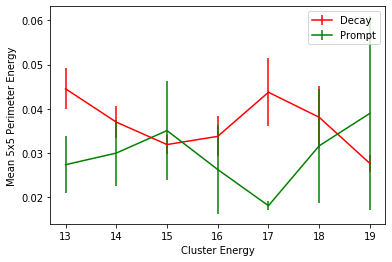

In [1386]:
#prompt = make2dHistTrend(pdata,x,y)
energybins = [13,14,15,16,17,18,19,20]
dmeans = myBinnedStat(groups.get_group(0)['total_energy'],groups.get_group(0)['max_perimeter'],energybins)
pmeans = myBinnedStat(groups.get_group(1)['total_energy'],groups.get_group(1)['max_perimeter'],energybins)
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in dmeans],yerr=[m.s for m in dmeans])
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in pmeans],yerr=[m.s for m in pmeans])
plt.xlabel("Cluster Energy")
plt.ylabel("Mean 5x5 Perimeter Energy")
plt.legend(["Decay","Prompt"])

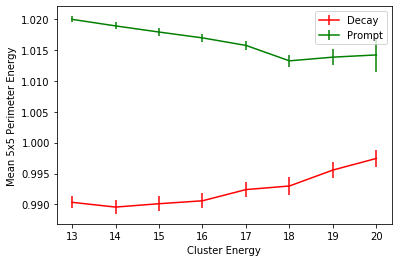

In [1391]:
#prompt = make2dHistTrend(pdata,x,y)
energybins = [13,14,15,16,17,18,19,20,21]
dmeans = myBinnedStat(groups.get_group(0)['total_energy'],groups.get_group(0)['core_energy'],energybins)
pmeans = myBinnedStat(groups.get_group(1)['total_energy'],groups.get_group(1)['core_energy'],energybins)
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in dmeans],yerr=[m.s for m in dmeans])
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in pmeans],yerr=[m.s for m in pmeans])
plt.xlabel("Cluster Energy")
plt.ylabel("Mean 5x5 Perimeter Energy")
plt.legend(["Decay","Prompt"])

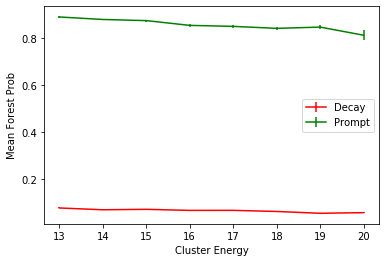

In [1397]:
dmeans = myBinnedStat(groups.get_group(0)['total_energy'],randomForest.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1],energybins)
pmeans = myBinnedStat(groups.get_group(1)['total_energy'],randomForest.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1],energybins)
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in dmeans],yerr=[m.s for m in dmeans])
plt.errorbar(energybins[0:len(energybins)-1],[m.n for m in pmeans],yerr=[m.s for m in pmeans])
plt.xlabel("Cluster Energy")
plt.ylabel("Mean Forest Prob")
plt.legend(["Decay","Prompt"])

In [1398]:
randomForest.best_param()

{'n_estimators': 100}


In [ ]:
diagnoseForest(randomForest.classifier.best_estimator_,list(train.drop('isPhoton',axis=1)))

Feature ranking:
1. tower24 (0.134277)
2. max_perimeter (0.090994)
3. core_energy (0.087505)
4. tower25 (0.061090)
5. tower23 (0.061062)
6. total_energy (0.059426)
7. tower31 (0.059171)
8. tower17 (0.058977)
9. left_asymmetry (0.057755)
10. top_asymmetry (0.057010)
11. integrated_perimeter (0.049628)
12. tower16 (0.042674)
13. tower30 (0.041681)
14. tower32 (0.040559)
15. tower18 (0.038679)
16. tower38 (0.021647)
17. tower37 (0.020139)
18. tower39 (0.017724)


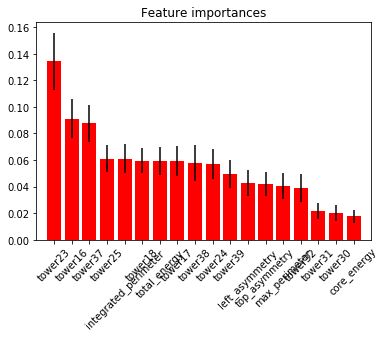

In [1399]:
forestImportance(randomForest.classifier.best_estimator_,list(train.drop('isPhoton',axis=1)))

In [1384]:
svc = SVC(train,test)

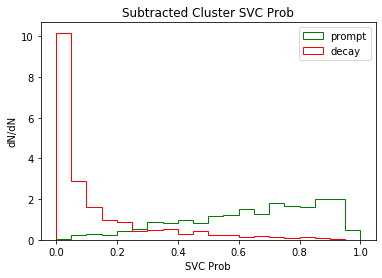

In [1394]:
groups = test.groupby(['isPhoton'])
plt.hist([svc.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , randomForest.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("SVC Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster SVC Prob")
plt.legend()
plt.show()

In [1385]:
svc.score()

SVC
	 F1: 0.0
	 Precision: 0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Recall: 0.0
	 Kappa: 0.0
	 Matrix: [[1531.796    0.   ]
 [  66.7      0.   ]]


In [949]:
bdt = BDT(train,test)

In [ ]:
bdt.score()

In [ ]:
bdt.best_param()

In [ ]:
groups = test.groupby(['isPhoton'])
plt.hist([bdt.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , bdt.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=10,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("BDT Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster BDT Prob")
plt.legend()
plt.show()

In [ ]:
mlp = MLP(train,test)

In [ ]:
groups = test.groupby(['isPhoton'])
plt.hist([bdt.estimate(groups.get_group(0).drop(['isPhoton'],axis=1))[:,1]  , mlp.estimate(groups.get_group(1).drop(['isPhoton'],axis=1))[:,1]], bins=20,density=True,histtype='step',label=["decay","prompt"])
plt.xlabel("MLP Prob")
plt.ylabel("dN/dN")
plt.title("Subtracted Cluster MLP Prob")
plt.legend()
plt.show()

In [ ]:
mlp.score()

In [ ]:
mlp.best_param()

Logistic
RandomForest
SVC


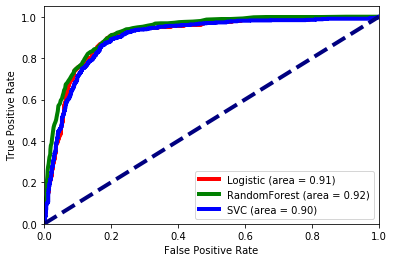

In [1392]:
algos = [logistic,randomForest,svc]
plotRoc(algos)

Logistic
RandomForest
SVC


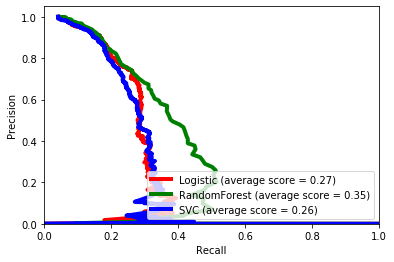

In [1393]:
algos = [logistic,randomForest,svc]
plotPRC(algos)

In [ ]:
for algo in algos:
    algo.score()

In [896]:
def clusterMap(event):
    cluster = []
    for i in range(0,7):
        row=[]
        for j in range(0,7):
            if event['tower'+str(7*i+j)] != -999:
                row.append(event['tower'+str(7*i+j)])
            else:
                row.append(0)
        cluster.append(row)
    cluster = np.array(cluster)
    fig, ax = plt.subplots()
    p = ax.imshow(cluster,)
    for i in range(0,7):
        for j in range(0,7):
            text = ax.text(j, i, round(cluster[i, j], 2),
                       ha="center", va="center", color="w")
    ax.set_title(round(event['total_energy'],2))


In [1267]:
def csvNoMix(signal):
    df = pd.read_csv(signal)
    df = df.groupby(['isPhoton']).get_group(1)
    df = df.drop(['isPhoton'], axis=1)
    df['pid'] = df['pid'].apply(removeCombined)
    df = df.dropna()
    df['pid'] = df['pid'].apply(pid2Type)
    df = df.rename(columns = {'pid':'isPhoton'})
    df = df[df['total_energy']<22]
    df = df[df['total_energy']>13]
    return df

In [898]:
signal = csvNoMix("singleclusters.csv")
back = csvNoMix("sback.csv")

Prompt Events
forest
[[0.8975 0.1025]
 [0.6425 0.3575]
 [0.1325 0.8675]
 [0.     1.    ]
 [0.0225 0.9775]
 [0.8475 0.1525]
 [0.145  0.855 ]]
[0. 0. 1. 1. 1. 0. 1.]


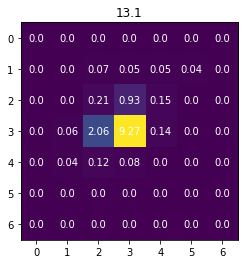

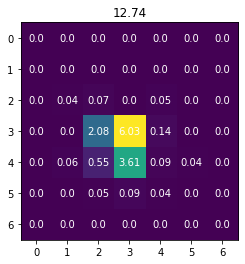

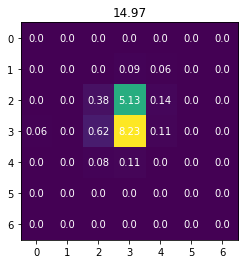

In [899]:
print("Prompt Events")
clusterMap(signal.iloc[6])
clusterMap(signal.iloc[1])
clusterMap(signal.iloc[2])

signalp  = preprocess (signal)
signalp = signalp.drop(['isPhoton','sProb','cal_energy'],axis=1)
print("forest")
print(randomForest.classifier.predict_proba([signalp.iloc[i] for i in range(0,7)]))
print(randomForest.predict([signalp.iloc[i] for i in range(0,7)]))



Decay Events


array([[0.9975, 0.0025],
       [0.8475, 0.1525],
       [0.8825, 0.1175]])

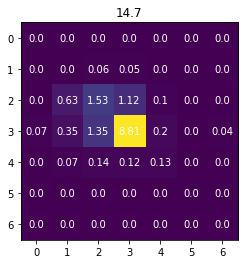

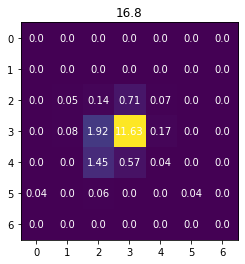

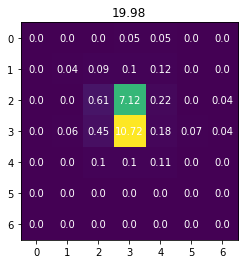

In [900]:
print("Decay Events")
clusterMap(back.iloc[0])
clusterMap(back.iloc[1])
clusterMap(back.iloc[2])

backp  = preprocess (back)
backp = backp.drop(['isPhoton','sProb',"cal_energy"],axis=1)
randomForest.classifier.predict_proba([backp.iloc[i] for i in range(0,3)])



In [901]:
randomForest.predict()

TypeError: predict() missing 1 required positional argument: 'cluster'